## 10. Skeleton Analysis

An image skeleton is a simplified, thin version of a binary image that captures its essential structure while removing unnecessary details. The skeleton represents the shape and topology of the object(s) in the image, often as a one-pixel-wide line or curve, without changing the overall connectivity or geometry of the structure.

In computer vision, skeletonization has numerous applications. It is used to extract and analyze the geometric properties of objects, such as their length, width, and topology. By simplifying features, it aids in tasks like handwritten character recognition and object identification. Skeletons also help generate central paths in road networks, veins in leaves, and vascular structures, supporting robotic navigation and biological studies. Additionally, they are valuable in medical imaging for analyzing anatomical structures such as blood vessels, airways, and bones.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2

from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects

## 10.1. Skeletonize

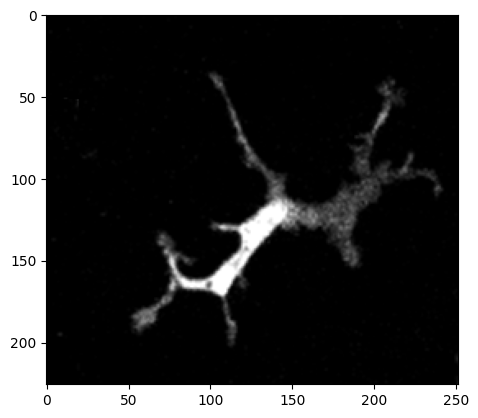

In [2]:
cell_image = cv2.imread('images/glialcells.png', 0)
plt.imshow(cell_image, cmap='gray')

**Exercise 10.1**

Convert `cell_image` to a binary image and skeletonize it (`cell_skeleton_image`). Expected output is similar to the one below:

<img src='images/glial_skeleton.png'>

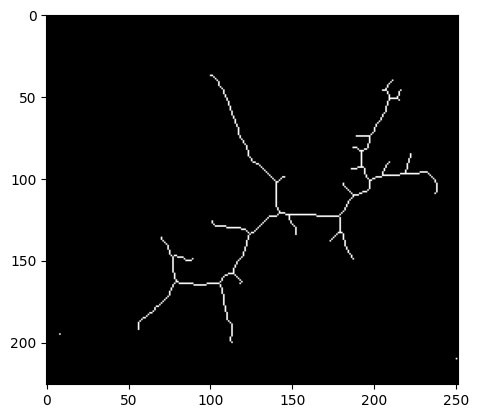

In [3]:
# YOUR CODE HERE
blur = cv2.GaussianBlur(cell_image, (3, 3), 0)

_, binary = cv2.threshold(blur, 17, 60,
                          cv2.THRESH_BINARY)
cell_skeleton_image = skeletonize(binary)
plt.imshow(cell_skeleton_image, cmap='gray')

## 10.2. Skeleton analysis with Skan

Skan is a pure Python library to analyse skeleton images. First, [install skan](https://skeleton-analysis.org/stable/getting_started/install.html).

In [4]:
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph

To analyze a skeleton, you need to have a basic understanding of [graph theory](https://en.wikipedia.org/wiki/Graph_theory) - the study of graphs. Graphs are mathematical structures that are used to model pairwise relations between objects.

A skeleton is a pixel graph. I will use the following image with two simple skeletons to explain skeleton analysis.

(-0.5, 7.5, 4.5, -0.5)

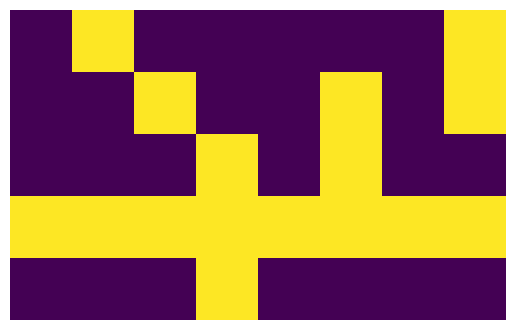

In [5]:
simple_skeleton_image = np.array([
    [0, 1, 0, 0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, 0, 0, 0, 0]])
plt.imshow(simple_skeleton_image)
plt.axis('off')

This image contains two skeletons. If we were to think of a skeleton as a pixel graph, each pixel will be a node (also called vertices). Nodes are connected with edges. Nodes are represented by labeled circles. Node 0, Node 1 etc. Edges connect the nodes and represented by lines (sometimes with arrows).

`skan` allows us to easily convert skeletons to graphs.

<Axes: >

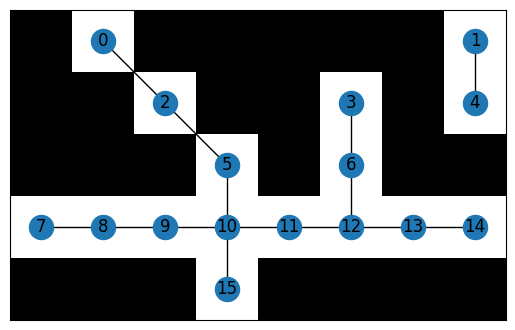

In [6]:
from skan import draw
g0, c0 = skeleton_to_csgraph(simple_skeleton_image)
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(g0, np.transpose(c0), image=simple_skeleton_image, axis=ax)

As you can see each pixel is a node, labeled from 0 to 15. Labeling starts from top left node with id 0, moves from left to right, top to bottom.

**Exercise 10.2**

If you convert `cell_skeleton_image` to a graph, how many nodes would there be? Answer the question without converting the skeleton to a graph.

In [7]:
# YOUR CODE HERE
n_nodes = np.count_nonzero(cell_skeleton_image)
print("Number of nodes:", n_nodes)

Number of nodes: 590


Edges can have weights. For skeleton analysis we can consider edge weights as the distances between the pixels.


Going back to our simple skeleton, the distance between the nodes 0 and 2 is $\sqrt{2} px$, the distance between nodes 5 and 10 is $1 px$.

**Exercise 10.3**

1) What is the path distance between Node 0 and Node 7?

2) What is the path distance between Node 5 and Node 11? (It is not $\sqrt{2} px$)

In [8]:
# YOUR CODE HERE
from math import sqrt
# as far as i understand diagonally == sqrt(2), vrtically/horizontally == 1
sqr2 = sqrt(2)

n0n7 = sqr2 + sqr2 + 4
print('n0 to n7:', n0n7)

n5n11 = 2
print('n5 to n11:', n5n11)

n0 to n7: 6.82842712474619
n5 to n11: 2


Nodes have types (also called degree), depending on how many neighbors they have.

- Degree zero: Isolated node, no neighbors
- Degree one: Endpoint, one neighbor (e.g. Nodes 0, 15)
- Degree two: Path node, two neighbors (e.g Nodes 2, 13)
- Degree three or more: Junction, three neighbors or more (e.g Nodes 10, 12)

**Exercise 10.4**

What is the type of Node 7?

A branch is a path that connects two nodes, where the path starts at one node (endpoint or a junction) and ends at another node (endpoint or a junction). Nodes are connected only by path nodes.

Let's look at the graph graph (pun intended) again to see the branches:

<Axes: >

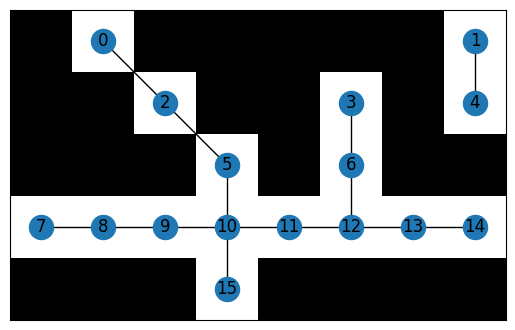

In [9]:
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(g0, np.transpose(c0), image=simple_skeleton_image, axis=ax)

You can see 7 branches here:

- Node 0 to 10
- Node 1 to 4
- Node 3 to 12
- Node 7 to 10
- Node 10 to 12
- Node 10 to 15
- Node 12 to 14

sorted by the starting node id.

For each branch, we can also note down the path length. For example for the branch between Node 0 and 10 the path length is $\sqrt{2}+\sqrt{2}+1=3.8284$. This is hardwork even for a small skeleton. Fortunately, skan can do this for us:

In [10]:
skeleton_object = Skeleton(simple_skeleton_image)

In [11]:
type(skeleton_object)

skan.csr.Skeleton

In [12]:
branch_data = summarize(skeleton_object)
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,10,3.828427,1,1.0,0.0,0,1,3,3,0,1,3,3,3.605551
1,1,1,4,1.000000,0,1.0,0.0,0,7,1,7,0,7,1,7,1.000000
2,0,3,12,2.000000,1,1.0,0.0,1,5,3,5,1,5,3,5,2.000000
3,0,7,10,3.000000,1,1.0,0.0,3,0,3,3,3,0,3,3,3.000000
4,0,10,12,2.000000,2,1.0,0.0,3,3,3,5,3,3,3,5,2.000000
5,0,10,15,1.000000,1,1.0,0.0,3,3,4,3,3,3,4,3,1.000000
6,0,12,14,2.000000,1,1.0,0.0,3,5,3,7,3,5,3,7,2.000000


Verify the path length we calculated above "For example for the branch between Node 0 and 10 the path length is $\sqrt{2}+\sqrt{2}+1=3.8284$." using the `branch_data`

- each row is a branch
- each column is a branch property
- skeleton-id: we have two skeletons therefore two ids 0 and 1.
- node-id-src: the id of the node branch starts from (source node)
- node-id-dst: the id of the node branch ends at (destination node)
- branch-distance: this is path length between the source and destination nodes.
- brach-type:
    - 0: endpoint-to-endpoint
    - 1: junction-to-endpoint
    - 2: junction-to-junction
    - 3: isolated cycle
- src coordinates: (x, y) coordinates of where the branch starts from
- dst coordinates: (x, y) coordinates of where the branch ends at

**Exercise 10.5**

Calculate branch data for `cell_skeleton_image`.  How many branches are there? How long is the longest branch?

In [13]:
# YOUR CODE HERE
skeleton_object = Skeleton(cell_skeleton_image)
branch_data = summarize(skeleton_object)
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,229,83.325902,1,1.0,0.0,37,100,102,140,37,100,102,140,76.321688
1,0,5,19,7.656854,1,1.0,0.0,40,211,46,207,40,211,46,207,7.211103
2,0,17,19,2.000000,1,1.0,0.0,46,205,46,207,46,205,46,207,2.000000
3,0,19,34,5.828427,2,1.0,0.0,46,207,51,209,46,207,51,209,5.385165
4,0,20,39,5.828427,1,1.0,0.0,46,216,51,214,46,216,51,214,5.385165
5,0,34,39,5.000000,2,1.0,0.0,51,209,51,214,51,209,51,214,5.000000
6,0,34,94,27.970563,2,1.0,0.0,51,209,74,197,51,209,74,197,25.942244
7,0,39,42,1.414214,1,1.0,0.0,51,214,52,215,51,214,52,215,1.414214
8,0,86,94,8.000000,1,1.0,0.0,74,189,74,197,74,189,74,197,8.000000
9,0,94,118,12.242641,2,1.0,0.0,74,197,83,192,74,197,83,192,10.295630


To learn what other information you can extract from a `skan.csr.Skeleton` object check the documentation:

https://skeleton-analysis.org/stable/api/skan.csr.html

For example you can path_coordinates of any branch on `branch_data` as follows:

In [14]:
# branch 0
skeleton_object.path_coordinates(0)

array([[ 37, 100],
       [ 37, 101],
       [ 38, 102],
       [ 39, 103],
       [ 40, 104],
       [ 41, 105],
       [ 42, 105],
       [ 43, 105],
       [ 44, 106],
       [ 45, 107],
       [ 46, 108],
       [ 47, 108],
       [ 48, 108],
       [ 49, 109],
       [ 50, 109],
       [ 51, 110],
       [ 52, 110],
       [ 53, 111],
       [ 54, 111],
       [ 55, 111],
       [ 56, 112],
       [ 57, 112],
       [ 58, 112],
       [ 59, 113],
       [ 60, 113],
       [ 61, 113],
       [ 62, 114],
       [ 63, 114],
       [ 64, 115],
       [ 65, 115],
       [ 66, 115],
       [ 67, 116],
       [ 68, 116],
       [ 69, 117],
       [ 70, 117],
       [ 71, 117],
       [ 72, 117],
       [ 73, 117],
       [ 74, 118],
       [ 75, 118],
       [ 76, 119],
       [ 77, 120],
       [ 78, 120],
       [ 79, 121],
       [ 80, 122],
       [ 81, 122],
       [ 82, 122],
       [ 83, 123],
       [ 84, 123],
       [ 85, 123],
       [ 86, 123],
       [ 87, 124],
       [ 88,

## 10.3. Extending skeleton analysis with NetworkX

`skan` is very useful for extracting the branches. If you want to analyze the combination of branches, `networkx` is the way to go. NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. Before moving to the code, [install networkx](https://networkx.org/documentation/stable/install.html).

In [15]:
import networkx as nx

In [ ]:
skeleton_object = Skeleton(simple_skeleton_image)
branch_data = summarize(skeleton_object)

In [27]:
# This is how we can convert the output of skan to a NetworkX graph
G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

We can obtain basic graph properties very easily:

In [28]:
G.nodes

NodeView((0, 10, 1, 4, 3, 12, 7, 15, 14))

In [29]:
G.number_of_nodes()

9

In [30]:
G.number_of_edges()

7

At this point you know connected components very well. But did you think about how it works? It is graph theory 🤯

In [31]:
# Now you know connected components come from graph theory
list(nx.connected_components(G))

[{0, 3, 7, 10, 12, 14, 15}, {1, 4}]

Let's demonstrate the usefulness of networkx over skan by measuring the shortest path between any two nodes. Note that in our case there is always a single path between any two node. But it is possible to have multiple paths between two nodes. Let's take a look at the graph again:

<Axes: >

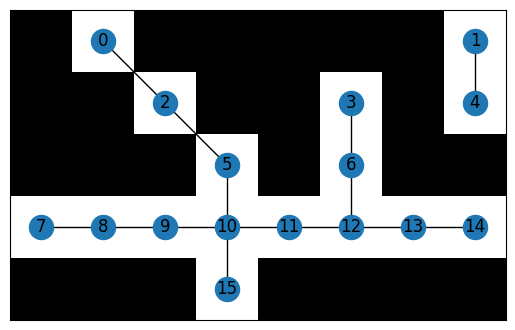

In [32]:
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(g0, np.transpose(c0), image=simple_skeleton_image, axis=ax)

What is the length of the shortest path between Node 7 and 3? We can answer this question by counting the edges, which is 7. Let's verify this with `networkx`:

In [33]:
path_list = nx.dijkstra_path(G, 7, 3, weight='branch-distance')
path_list

[7, 10, 12, 3]

In [34]:
path_len = nx.dijkstra_path_length(G, 7, 3, weight='branch-distance')
path_len

7.0

**Exercise 10.6**

Select two endpoints in the cell skeleton, find the shortest path and its length.


In [35]:
# YOUR CODE HERE
skeleton_object = Skeleton(cell_skeleton_image)
branch_data = summarize(skeleton_object)
G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

print(G.nodes)
print(G.number_of_nodes())
print(G.number_of_edges())

[0, 229, 5, 19, 17, 34, 20, 39, 94, 42, 86, 118, 108, 154, 124, 185, 140, 197, 159, 226, 263, 211, 265, 289, 234, 334, 297, 392, 393, 390, 341, 409, 451, 476, 399, 440, 449, 490, 511, 512, 578, 588]
42
41


In [36]:
path_list = nx.dijkstra_path(G, 5, 86, weight='branch-distance')
path_list

[5, 19, 34, 94, 86]

In [37]:
path_len = nx.dijkstra_path_length(G, 5, 86, weight='branch-distance')
path_len

49.45584412271572

**Exercise 10.7**

Read the following Wikipedia articles:

- [Dijkstra's algorithm wiki article](https://en.wikipedia.org/wiki/Dijkstra's_algorithm).

- [Edsger W. Dijkstra](https://en.wikipedia.org/wiki/Edsger_W._Dijkstra)

Where was Dijkstra when he came up with the idea for his shortest path algorithm? ☕

In a café in Amsterdam